In [1]:
#read all files in dataset. divide them in acted videos and real videos

import os
from datetime import datetime

dataset_root = "./dataset"
dataset_classes_dirs = [os.path.join(dataset_root, "%d"%i) for i in range(1,6)]

dataset_acted = {}
dataset_real = {}
for videos_dir in dataset_classes_dirs:
    class_id = videos_dir[-1]
    dataset_acted[class_id] = []
    dataset_real[class_id] = []
    videos_names = os.listdir(videos_dir)
    for video_name in videos_names:
        if (not "golden5s" in video_name and not "ipod5" in video_name and not "black5" in video_name) or \
          (datetime.strptime(video_name.split("_")[3],"%Y-%m-%d") <= datetime(2016,6,20)): 
            dataset_acted[class_id].append(video_name)
        else:
            dataset_real[class_id].append(video_name)
            
print "dataset_acted"
print {class_id:len(dataset_acted[class_id]) for class_id in sorted(dataset_acted.keys())}

print "dataset_real"
print {class_id:len(dataset_real[class_id]) for class_id in sorted(dataset_real.keys())}

dataset_acted
{'1': 198, '3': 80, '2': 291, '5': 535, '4': 64}
dataset_real
{'1': 201, '3': 278, '2': 52, '5': 202, '4': 138}


In [2]:
import json

video_owners_filepath="./video_owners.json"
with open(video_owners_filepath) as f:
    video_owners = json.load(f)

In [3]:
# discard videos that are corrupted.
not_found = []
for class_id in dataset_real.keys():
    videos = dataset_real[class_id]
    for v in videos:
        v_group = video_owners.get(v)
        if not v_group:
            not_found.append((v,class_id))

print "not found:", len(not_found)
for v,c in not_found:
    dataset_real[c].remove(v)
    
groups = {}
for class_id in dataset_real.keys():
    videos = dataset_real[class_id]
    for v in videos:
        v_group = video_owners.get(v).split("_")[0]
            
        if not groups.get(v_group):
            groups[v_group] = [(v,class_id)]
        else:
            groups[v_group].append((v,class_id))
            
print "total_different_people:",len(groups.keys())
#print groups.keys()
print {g:len(groups[g]) for g in groups.keys()}

not found: 42
total_different_people: 11
{u'Julien': 27, u'Luke': 15, u'Charles': 49, u'Victor': 98, u'Marge': 88, u'Henry': 192, u'Fiona': 30, u'Anne': 238, u'Peter': 38, u'Irene': 7, u'Rick': 47}


In [4]:
fold_nr = 0
fold_path="./folds/"
generate_on_the_fly=True

training_h5py_path=os.path.join(fold_path,"%d"%fold_nr, "training.h5")
val_h5py_path=os.path.join(fold_path,"%d"%fold_nr, "validation.h5")

In [5]:
#generate training and validation lists with format 'frame_path class'
import random
from sklearn.utils import compute_class_weight
import numpy as np

def generate_training_validation_dataset(training_proportion=0.8, fold_nr=fold_nr, 
                                         fold_path=fold_path,
                                         dataset_root="./dataset",
                                         balance_training=False):
    training = []
    val = []
    
    for c in dataset_acted.keys():
        training.extend([(v,c) for v in dataset_acted[c]])
        #print len(dataset_acted[c])
        #subset = random.sample(dataset_acted[c], (len(dataset_acted[c])*0.8))
        #training.extend([(v,c) for v in subset])
        #val.extend([(v,c) for v in dataset_acted[c] if v not in subset])
    
    #first fold:
    #val = ['Anne',"Luke","Fiona","Irene", 'Julien', 'Victor']
    subset = ["Peter", 'Marge', "Henry", "Rick", 'Charles', ]
    
    #val = ["Henry","Rick","Luke","Fiona","Irene"]
    #subset = ["Peter", 'Marge', 'Charles', 'Anne', 'Victor', 'Julien']
    [training.extend(groups[g]) for g in subset]
    [val.extend(groups[g]) for g in groups.keys() if g not in subset]
    
    print "Training frames distribution"
    count_training = [0,0,0,0,0]
    for v,c in training:
        count_training[int(c)-1] += len(os.listdir(os.path.join(dataset_root,c,v)))
    
    #balancing training set
    min_class_len = min(count_training)
    max_class_len = max(count_training)
    print max(count_training),min_class_len
    
    frames_training = []
    for v,c in training:
        video_path = os.path.join(dataset_root,c,v)
        frames = os.listdir(video_path)
        for fr in frames:
            frames_training.append((os.path.join(video_path,fr),int(c)-1))
            
    if balance_training:
        while max_class_len != min(count_training):
            v,c = random.choice(frames_training)
            c_id = c
            if count_training[c_id] < max_class_len:
                frames_training.append((v,c))
                count_training[c_id] +=1

    print count_training
    
    print "Validation frames distribution"
    count_val = [0,0,0,0,0]
    for v,c in val:
        count_val[int(c)-1] += len(os.listdir(os.path.join(dataset_root,c,v)))
        
    print count_val
    
    frames_validation = []
    for v,c in val:
        video_path = os.path.join(dataset_root,c,v)
        frames = os.listdir(video_path)
        for fr in frames:
            frames_validation.append((os.path.join(video_path,fr),int(c)-1))
    
    training_filepath = os.path.join(fold_path,"%d"%fold_nr, "training_list.txt")
    val_filepath = os.path.join(fold_path,"%d"%fold_nr, "validation_list.txt")
    
    if not os.path.isdir(os.path.dirname(training_filepath)):
        os.makedirs(os.path.dirname(training_filepath))
        
    for fil,dataset in [(training_filepath, frames_training), 
                        (val_filepath,frames_validation)]:
        with open(fil,"w") as f:
            for fr,c in dataset:
                f.write("%s %d\n"%(fr,c))
    
    category_weights = compute_class_weight('balanced', range(5), np.array([c for fr,c in frames_training]))
    print "Class weights", category_weights
    return training_filepath, val_filepath, category_weights
                
#training_file,val_file,category_weights = generate_training_validation_dataset(balance_training=True)

training_file,val_file = os.path.join(dataset_root,"training_list.txt"), os.path.join(dataset_root,"validation_list.txt")

with open(training_file) as f:
    lines = f.readlines()

cat_count = []    
for l in lines:
    path,c = l.split()
    cat_count.append(int(c))
    
category_weights = compute_class_weight('balanced', range(1,6), np.array(cat_count))
print category_weights

[ 1.  1.  1.  1.  1.]


Category: 1


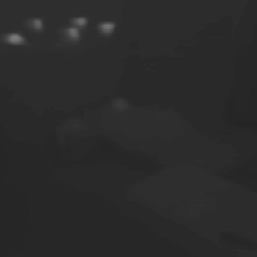

Category: 2


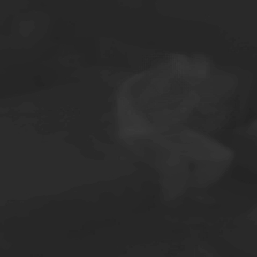

Category: 3


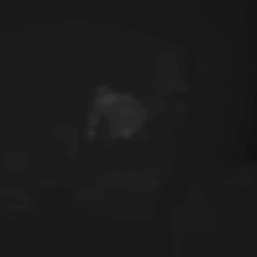

Category: 4


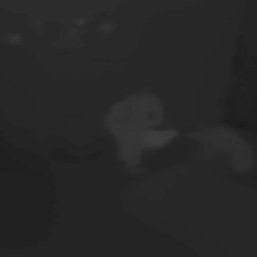

Category: 5


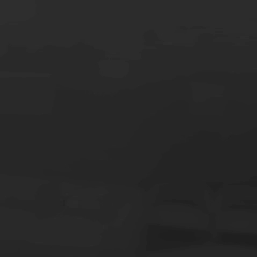

Category: 4


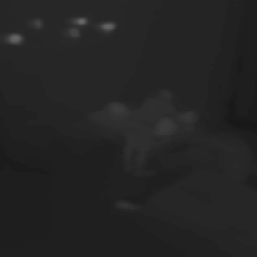

Category: 3


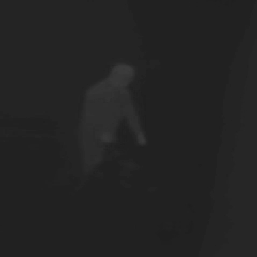

Category: 5


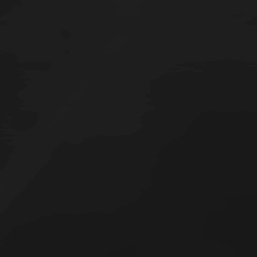

Category: 1


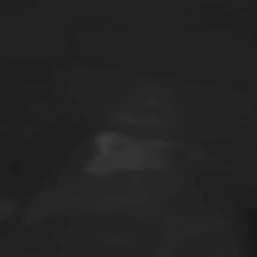

Category: 2


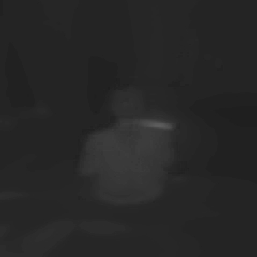

In [6]:
from PIL import Image
from IPython.display import display
import random

with open(training_file) as f:
    lines = f.readlines()

for l in random.sample(lines, 10):
    path = l.split()[0]
    img=Image.open(os.path.join(dataset_root,path))
    print "Category:",l.split()[1]
    display(img)

In [7]:
#save training dataset in h5py format
from training_utils import build_hdf5_thermal_image_dataset

if not os.path.exists(training_h5py_path) and not generate_on_the_fly:
    build_hdf5_thermal_image_dataset(training_file, (224,224), 
                         output_path=training_h5py_path,
                             mode='file', categorical_labels=True,
                             normalize=False, grayscale=True, root_path=dataset_root)

In [8]:
#save validation dataset in h5py format
from training_utils import build_hdf5_thermal_image_dataset

if not os.path.exists(val_h5py_path) and not generate_on_the_fly:
    build_hdf5_thermal_image_dataset(val_file, (224,224), 
                         output_path=val_h5py_path,
                             mode='file', categorical_labels=True,
                             normalize=False, grayscale=True,root_path=dataset_root)

In [9]:
import tflearn, tensorflow as tf
from tflearn.layers.core import input_data, dropout, fully_connected,reshape
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import batch_normalization#local_response_normalization
from tflearn.layers.estimator import regression
from training_utils import ThermalImageAugmentation, thermal_image_preloader

def model(category_weights=[1.,1.,1.,1.,1.]):
    
    img_aug = ThermalImageAugmentation()
    # Random flip an image
    img_aug.add_random_flip_leftright()
    img_aug.add_random_temperature_fluctuation(max_degrees_change=5)
    img_aug.add_random_blur(sigma_max=0.2)
    
    cat_weights_c = tf.constant(category_weights, tf.float32)
    
    tf_data = tf.placeholder(tf.float32, shape=(None, 224, 224))
    network = input_data(placeholder=tf_data)
    
    network = reshape(network, [-1,224,224,1])
    
    network = batch_normalization(network)
    
    network = conv_2d(network, 96, 7, strides=2, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = batch_normalization(network)
    network = dropout(network, 0.5)
    
    #network = local_response_normalization(network)
    network = conv_2d(network, 256, 5, strides=2, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = batch_normalization(network)
    network = dropout(network, 0.5)
    
    #network = local_response_normalization(network)
    network = conv_2d(network, 384, 3, activation='relu')
    network = batch_normalization(network)
    network = dropout(network, 0.5)
    
    network = conv_2d(network, 384, 3, activation='relu')
    network = batch_normalization(network)
    network = dropout(network, 0.5)
    
    
    network = conv_2d(network, 256, 3, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = batch_normalization(network)
    network = dropout(network, 0.5)
    
    #network = local_response_normalization(network)
    network = fully_connected(network, 5, activation='linear')
    network = tf.mul(network, cat_weights_c)
    network = tflearn.activations.softmax (network)
    
    return network, tf_data

name = datetime.strftime(datetime.now(),'%Y-%m-%d_%H%M%S')
model_dir = "./checkpoints"

net, _ = model(category_weights)
net = regression(net, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)
batch_size = 256
epochs = 500

if generate_on_the_fly:
    X, Y = thermal_image_preloader(training_file, (224,224), 
                             mode='file', categorical_labels=True,
                             normalize=False, grayscale=True,root_path=dataset_root)
    v_X,v_Y = thermal_image_preloader(val_file, (224,224), 
                             mode='file', categorical_labels=True,
                             normalize=False, grayscale=True,root_path=dataset_root)
else:
    import h5py
    h5f = h5py.File(training_h5py_path)
    X = h5f['X']
    Y = h5f['Y']

    v_h5f = h5py.File(val_h5py_path)
    v_X = v_h5f['X']
    v_Y = v_h5f['Y']

# Training
model = tflearn.DNN(net, checkpoint_path=os.path.join(model_dir, name, 'checkpoint'),
                    tensorboard_dir=model_dir,
                    tensorboard_verbose=0)
model.fit(X, Y, n_epoch=1000, validation_set=(v_X,v_Y), shuffle=True,
          show_metric=True, batch_size=batch_size, snapshot_step=False,
snapshot_epoch=True, run_id=name)

Training Step: 464  | total loss: 0.12609
| Adam | epoch: 006 | loss: 0.12609 - acc: 0.9656 -- iter: 02304/23085


KeyboardInterrupt: 